# Objective

Can we downscale the images so cell counting is faster -- while still getting good cell counts?

# Images used

71 raw images (cropped, not pre-rescaled) were used to find linear transformation parameters. The same images were also used to find blob_dog() intensity thresholds for images with and without bubbles, using `benchmark_blob_dog_find_thresh_w_normxcorr2.ipynb`.

# Preprocessing

normxcorr2 (from https://github.com/czbiohub/cell-counting-imager/blob/828b8af950beb32ff76548f11764c8915bb9b6d6/cell_counting_imager/normxcorr2.py)

downsampling (from https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.downscale_local_mean)

# Results

Downscaling the image even by 2 (which is the smallest integer after 1) does not work.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from normxcorr2 import normxcorr2
from skimage.feature import blob_dog
from skimage.io import imread
from skimage import exposure, transform
from scipy.stats import linregress
from matplotlib.lines import Line2D
import warnings, math
warnings.filterwarnings('ignore')

In [4]:
def cross_correlate(im):
    im_normxcorr2 = normxcorr2(kernel, im)
    lr_edge = (im_normxcorr2.shape[0] - im.shape[0])/2
    ud_edge = (im_normxcorr2.shape[1] - im.shape[1])/2
    return im_normxcorr2[int(ud_edge):int(ud_edge*-1), int(ud_edge):int(ud_edge*-1)]

In [5]:
# using default kernel params
kernelSize = 140
ds = 2 # down-sampling integer factor along each axis
discRadius = 3

In [6]:
# set up kernel
kernel = np.zeros((kernelSize, kernelSize), 'uint16')
kernelCtr = kernelSize/2
for rr in range(0, kernelSize + 1):
    for cc in range(0, kernelSize + 1):
        if  math.sqrt((rr - kernelCtr)**2 + (cc - kernelCtr)**2) < discRadius:
            kernel[rr, cc] = 65535
kernel = transform.downscale_local_mean(kernel, (ds,ds))

# Test all 71 images

In [7]:
names_raw = pd.read_csv('names.csv', header=None)
names = [x[0][23:-4] for x in names_raw.values]

In [8]:
names_raw = pd.read_csv('names_test.csv', header=None)
names_test = [x[0][14:] for x in names_raw.values]

In [9]:
bubble_image_names = [
    '20200901-193536-2',
    '20200916-192532-4',
    '20201002-131101-4'
]

In [11]:
# bubble detection parameters
n = 12
l = 256

threshold = 0.1

In [12]:
ds = 2

In [13]:
import datetime

In [14]:
gt_counts, pred_counts, colors = [], [], []
print(datetime.datetime.now())
for i in range(len(names)):
    if i%10==0:
        print(i, '/', len(names))
    name = names[i]
    im = imread('raw_images_cropped/image-cropped-%s.tif' % name)
    im = transform.downscale_local_mean(im, (ds,ds))

    im = cross_correlate(im)
    df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
    blobs = blob_dog(im, min_sigma=5, max_sigma=15, threshold=0.1)
    gt_counts.append(len(df))
    pred_counts.append(len(blobs))
    if name in bubble_image_names:
        colors.append('m')
    else:
        colors.append('c')
print(datetime.datetime.now())

2021-02-09 23:40:37.405671
0 / 71
10 / 71
20 / 71
30 / 71
40 / 71
50 / 71
60 / 71
70 / 71
2021-02-09 23:40:58.949225


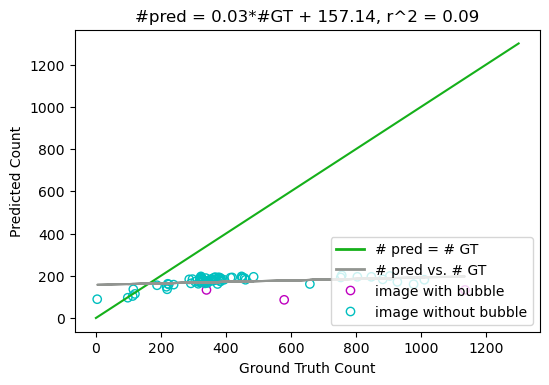

In [15]:
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(gt_counts, pred_counts, facecolor='None', edgecolor=colors)
plt.plot([0, 1300], [0, 1300], color='xkcd:green')
plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')

slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
plt.plot(gt_counts, intercept + [slope*x for x in gt_counts], color='xkcd:gray')
plt.title('#pred = %s*#GT + %s, r^2 = %s' % (str(round(slope,2)), str(round(intercept,2)), str(round(r_value**2,2))))

handle_list = []
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:green', lw=2, label='# pred = # GT'))
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:gray', lw=2, label='# pred vs. # GT'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='m', label='image with bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='c', label='image without bubble'))
plt.legend(handles=handle_list, loc='lower right', fontsize=10)

plt.show()